### Advanced Machine Learning

# Home Exercise #4

Assignment Due: 17/05/21 23:59

Jonathan Schler

In [1]:
student1Name="Alexander Kruglyak"
student1ID="323637736"


student2Name="Sofya Zubtsovsky"
student2ID="337839112"


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, LogisticRegressionCV, Lasso, RidgeCV, LassoCV, ElasticNet
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:f}'.format

The goal of this homework is to try to solve the problem of predicting wine quality from review texts and other properties of the wine. You can find the dataset here:https://www.kaggle.com/zynicide/wine-reviews

While you can find several kernels on kaggle already, I highly recommend you start your ownsolution from scratch. For this homework, only use wine from the United States (only 42% of data). Feel free to subsample the data for building your model.

## Task 1 Bag of Words and simple Features [50pts]

1.1 Create a baseline model for predicting wine quality using only non-text features.





In [3]:
def show_data_basic_information(df):
    print("Info\n")
    print(df.info())
    print("\n" + "*" * 10 + "\n")
    
    print("Shape\n")
    print(df.shape) 
    print("\n" + "*" * 10 + "\n")
    
    print("Amount of is null data\n")
    print(df.isnull().sum().max())
    print("\n" + "*" * 10 + "\n")
    
    print("Describe\n")
    display(df.describe())
    print("\n" + "*" * 10 + "\n")

In [17]:
def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1)


def get_categorical_features(df):
    return df.select_dtypes(include=['object'])


def get_continuous_features(df):
    return df.select_dtypes(exclude=['object'])


def drop_nan_price(_df):
    print('nan price before: ' + str(_df['price'].isna().sum()))
    df = _df.dropna(subset=['price'])
    print('nan price after: ' + str(df['price'].isna().sum()))
    return df


def take_us_wines(_df):
    df = _df[_df['country']=="US"]
    return df


def fill_categorical_nan_object_column(_df):
    df = _df.copy()
    print ('='*10 + " df as is\n"+'='*10,_df.isna().sum())
    categorical = get_categorical_features(_df)
    df[categorical.columns] = _df[categorical.columns].fillna("unknown")
    print ('='*10 + " df without NaN\n"+'='*10,df.isna().sum())
    return df


def get_dummies(_df,columns_to_dummy):
    df = _df.copy()
    df = pd.get_dummies(df,columns=columns_to_dummy)
    return df


def cat_feature_to_other(df, featureNames):
    _df = df.copy()
    for featureName in featureNames:
        total = len(_df[featureName].value_counts().index.to_list())
        to_default = total - 15
        less_popular = _df[featureName].value_counts().tail(to_default).index.tolist()
        _df[featureName].replace(to_replace=less_popular, value='other', inplace=True)
    return _df


def get_year_from_title(x):
    arr = x['title'].split()
    arr = [int(s) for s in arr if s.isdigit() and int(s) > 1800 and int(s) <= 2021]
    if len(arr) >= 1:
        return arr[0]
    return -1


def remove_anomally_hig_price(df):
    _df = df.copy()
    _df = _df[_df.price != np.max(_df.price)]
    return _df


def sanitize_description(df):
    _df = df.copy()
    _df['description'] = _df['description'].replace(b"<br />", b" ")
    return _df

COLS_TO_DUMMY = ['province','variety','region_1']
IRRELEVANT_COLS = ['Unnamed: 0','taster_name','taster_twitter_handle','country'] 


def prepare_data(df):
    _df = df.copy()

    _df = take_us_wines(_df)
    _df = drop_columns(_df,IRRELEVANT_COLS)
    _df = drop_nan_price(_df)
    _df = fill_categorical_nan_object_column(_df)
    _df = cat_feature_to_other(_df, COLS_TO_DUMMY)
    _df = get_dummies(_df, COLS_TO_DUMMY)
    _df['Wine_Year'] = _df.apply(get_year_from_title, axis=1)
    _df = remove_anomally_hig_price(_df)
    _df = sanitize_description(_df)
    
    return _df    

In [18]:
full_df = pd.read_csv("winemag-data-130k-v2.csv")

In [19]:
prepare_data(full_df)

nan price before: 239
nan price after: 0
========== df as is
========== description        0
designation    17514
points             0
price              0
province           0
region_1         276
region_2        3973
title              0
variety            0
winery             0
dtype: int64
========== df without NaN
========== description    0
designation    0
points         0
price          0
province       0
region_1       0
region_2       0
title          0
variety        0
winery         0
dtype: int64


,description,designation,points,price,region_2,title,winery,province_America,province_Arizona,province_California,...,region_1_Russian River Valley,region_1_Santa Barbara County,region_1_Sonoma Coast,region_1_Sonoma County,region_1_Sta. Rita Hills,region_1_Walla Walla Valley (WA),region_1_Willamette Valley,region_1_Yakima Valley,region_1_other,Wine_Year
2,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Rainstorm,0,0,0,...,0,0,0,0,0,0,1,0,0,2013
3,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,St. Julian,0,0,0,...,0,0,0,0,0,0,0,0,1,2013
4,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Sweet Cheeks,0,0,0,...,0,0,0,0,0,0,1,0,0,2012
10,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.000000,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,Kirkland Signature,0,0,1,...,0,0,0,0,0,0,0,0,0,2011
12,"Slightly reduced, this wine offers a chalky, t...",unknown,87,34.000000,Sonoma,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Louis M. Martini,0,0,1,...,0,0,0,0,0,0,0,0,1,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129945,Hailing from one of the more popular vineyards...,Jurassic Park Vineyard Old Vines,90,20.000000,Central Coast,Birichino 2013 Jurassic Park Vineyard Old Vine...,Birichino,0,0,1,...,0,0,0,0,0,0,0,0,1,2013
129949,There's no bones about the use of oak in this ...,Barrel Fermented,90,35.000000,Napa,Flora Springs 2013 Barrel Fermented Chardonnay...,Flora Springs,0,0,1,...,0,0,0,0,0,0,0,0,0,2013
129950,This opens with herbaceous dollops of thyme an...,Blocks 7 & 22,90,35.000000,Napa,Hendry 2012 Blocks 7 & 22 Zinfandel (Napa Valley),Hendry,0,0,1,...,0,0,0,0,0,0,0,0,0,2012
129952,This Zinfandel from the eastern section of Nap...,unknown,90,22.000000,Napa,Houdini 2011 Zinfandel (Chiles Valley),Houdini,0,0,1,...,0,0,0,0,0,0,0,0,1,2011


In [14]:


def get_label_and_drop(_df):
    df = _df.copy()
    label = df['points']
    df = drop_columns(df,['points'])
    return df, label

In [20]:
def print_unique_count(df):
    for (featureName, featureData) in df.select_dtypes(include=['object']).iteritems():
        print("{} has unique values: {}".format(featureName, featureData.nunique()))

In [21]:
def show_random_text(_df,feature,n=1):
    df = _df.sample(n=n,random_state=42)
    print(list(df[feature]))

In [22]:
show_random_text(us_df_filled,'description')

['This barrel-fermented white wine from Jesse Katz of Devil Proof and Aperture Wines is impressively layered and complex. A reductive whiff of petrol leads on the nose yet the palate is juicy, showing a wealth of peach skin and green apple. A bite of acidity supports its fresh, fruity core.']


In [23]:
show_random_text(us_df_filled,'designation',5)

['unknown', 'Patio', 'unknown', 'unknown', 'Spirit Canyon Vineyard']


In [24]:
show_random_text(us_df_filled,'title',10)

['The Setting 2016 Sauvignon Blanc (Sonoma County)', 'C&T; 2006 Patio Pinot Noir (Napa-Sonoma)', 'Thomas Fogarty 2004 Merlot (Santa Cruz Mountains)', 'Peter Cellars 2006 Cabernet Sauvignon (Chalk Hill)', 'Briceland 2016 Spirit Canyon Vineyard Arneis (Mendocino County)', 'Chimney Rock 2014 Estate Grown Cabernet Sauvignon (Stags Leap District)', 'Heron Hill 2009 Unoaked Ingle Vineyard Chardonnay (Finger Lakes)', 'Armanino Family Cellars 2013 The Pintail Pinot Noir (Napa Valley)', 'Truchard 2011 Chardonnay (Carneros)', 'Serdonis 2004 Ink Grade Vineyard Cabernet Sauvignon (Howell Mountain)']


In [25]:
show_random_text(us_df_filled,'variety',10)

['Sauvignon Blanc', 'Pinot Noir', 'Merlot', 'Cabernet Sauvignon', 'Arneis', 'Cabernet Sauvignon', 'Chardonnay', 'Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon']


In [26]:
show_random_text(us_df_filled,'winery',10)

['The Setting', 'C&T;', 'Thomas Fogarty', 'Peter Cellars', 'Briceland', 'Chimney Rock', 'Heron Hill', 'Armanino Family Cellars', 'Truchard', 'Serdonis']


In [27]:
show_random_text(us_df_filled,'region_1',10)

['Sonoma County', 'Napa-Sonoma', 'Santa Cruz Mountains', 'Chalk Hill', 'Mendocino County', 'Stags Leap District', 'Finger Lakes', 'Napa Valley', 'Carneros', 'Howell Mountain']


In [28]:
show_random_text(us_df_filled,'region_2',10)

['Sonoma', 'Napa-Sonoma', 'Central Coast', 'Sonoma', 'unknown', 'Napa', 'Finger Lakes', 'Napa', 'Napa-Sonoma', 'Napa']


In [29]:
print_unique_count(us_df_filled)

description has unique values: 50229
designation has unique values: 14131
province has unique values: 27
region_1 has unique values: 265
region_2 has unique values: 18
title has unique values: 50011
variety has unique values: 257
winery has unique values: 5368


In [30]:
us_df_filled.winery.value_counts().head(20)

Testarossa               217
Williams Selyem          211
Chateau Ste. Michelle    193
Columbia Crest           158
Kendall-Jackson          130
Siduri                   126
Gary Farrell             125
Lynmar                   118
Robert Mondavi           112
Fess Parker              108
V. Sattui                107
Iron Horse               106
Foxen                    105
Maryhill                 102
Chehalem                 102
Kunde                    101
Terre Rouge              100
Dutton-Goldfield         100
Kenwood                   98
Martin Ray                98
Name: winery, dtype: int64

## Linear models on numerical data

In [41]:
def add_score(scores_df, score, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'r2'] = np.mean(score)

In [42]:
def get_cross_val_score(scores_df,estimator,X_train,y_train,prefix="",sampler=None):
        name = estimator.__class__.__name__
        if estimator.__class__ is Pipeline:
            name = estimator.named_steps['estimator'].__class__.__name__
        pipe = estimator
        sampler_name = ""
        if sampler is not None:
            pipe = make_imb_pipeline(sampler(random_state=42), estimator)
            sampler_name = sampler.__name__
        print('*********' + name + ' ' + sampler_name + '*********')
        score = cross_val_score(
            pipe,
            X_train, 
            y_train, 
            cv=10,
            scoring=('r2'),
            n_jobs = -1
        )
        add_score(scores_df, score, name,prefix)

In [43]:
rergressors = [LinearRegression(),Ridge(),Lasso(),ElasticNet()] 
scores_df = pd.DataFrame(dtype=float)

In [44]:
X_num = get_continuous_features(us_df_cleaned)
X,y = get_label_and_drop(X_num)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)
X_train.describe()

,price,province_America,province_Arizona,province_California,province_Colorado,province_Idaho,province_Michigan,province_Missouri,province_New Mexico,province_New York,...,region_1_Paso Robles,region_1_Russian River Valley,region_1_Santa Barbara County,region_1_Sonoma Coast,region_1_Sonoma County,region_1_Sta. Rita Hills,region_1_Walla Walla Valley (WA),region_1_Willamette Valley,region_1_Yakima Valley,region_1_other
count,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,...,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000,40698.000000
mean,36.422920,0.001843,0.000835,0.664455,0.001302,0.003440,0.002138,0.000688,0.000885,0.050248,...,0.043147,0.056563,0.018502,0.026635,0.023687,0.018330,0.019657,0.041894,0.018158,0.463045
std,25.207302,0.042889,0.028892,0.472186,0.036064,0.058551,0.046186,0.026221,0.029729,0.218459,...,0.203191,0.231008,0.134760,0.161017,0.152073,0.134144,0.138820,0.200349,0.133525,0.498639
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,625.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"numerical")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.298435
Ridge_numerical,0.298444
Lasso_numerical,0.230605
ElasticNet_numerical,0.230707


Text(0.5, 1.0, 'Distribution of year')

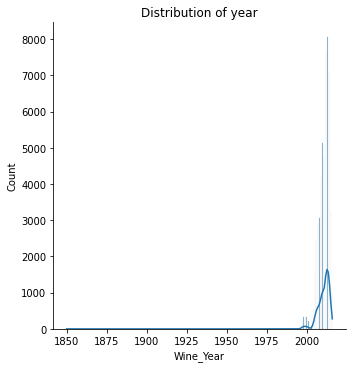

In [47]:
sns.displot(us_df_filled.loc[us_df_filled["Wine_Year"]!=-1,"Wine_Year"], kde=True)
plt.title("Distribution of year")

In [89]:

us_df_cleaned["Wine_Year"]=us_df_filled["Wine_Year"]

In [90]:
X_num = get_continuous_features(us_df_cleaned)
X,y = get_label_and_drop(X_num)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)

for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"_add_year")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression__char_wb,-0.160987
Lasso__count_vectorizer,-0.000694
ElasticNet__CountVectorizer_norma,-0.000694
Lasso__CountVectorizer_norma,-0.000694
ElasticNet__ngrm,-0.000694
ElasticNet_TfidfVectorizer,-0.000694
Lasso_TfidfVectorizer,-0.000694
ElasticNet__count_vectorizer,-0.000694
Lasso__ngrm,-0.000694
Lasso_TfidfVectorizer_combined,-0.000095


1.2 Create a simple text-based model using a bag-of-words approach and a linear model.


In [51]:
text_trainval = us_df_filled['description'].tolist()
y_trainval = us_df_filled['points']
print("type of text_train: ", type(text_trainval))
print("length of text_train: ", len(text_trainval))
print("class balance: ", np.bincount(y_trainval))

type of text_train:  <class 'list'>
length of text_train:  54264
class balance:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  157  326 1006 1304
 2667 3667 4904 6599 6978 4395 6684 5283 4505 3005 1793  640  221   81
   33   12    4]


In [52]:
text_trainval

['A good everyday Merlot, dry and rich in tannins, with pleasant cherry, cocoa, licorice, herb and spice flavors.',
 'Packaged in a cute yellow recyclable Tetrapak, this easy Chard is sweet in pineapple juice and green apple flavors, balanced with crisp acidity.',
 'Fruity, soft and rather sweet, this wine smells and tastes like apple and pear juice. It has low acidity, medium body and a sugary finish.',
 "There's a lot going on in this Merlot, which is likeable now for its rich blackberry, cherry, cranberry, cola and spice flavors. It's dry and balanced.",
 "Sweet and fruity, this canned wine feels soft and syrupy, with sugary pear as the primary flavor on the palate. It's a basic white wine in a convenient package.",
 "This sparkling wine is the best of ManCan's three new canned offerings. It has plenty of rich fruit flavors and a buttery note. Lively bubbles settle into the smooth, creamy texture, leaving an overall impression of easygoing enjoyment.",
 'This wine has a deep-gold co

In [54]:
text_train, text_val, y_train, y_val = train_test_split(text_trainval, y_trainval, stratify=y_trainval,random_state=0)

In [55]:
vect = CountVectorizer(stop_words='english',min_df=4)
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)
X_train

<40698x8217 sparse matrix of type '<class 'numpy.int64'>'
	with 959996 stored elements in Compressed Sparse Row format>

In [56]:
print(X_train.shape, y_train.shape)

(40698, 8217) (40698,)


In [57]:
#Vocabulary
feature_names = vect.get_feature_names()
print(feature_names[:10])
print(feature_names[20000:20020])
print(feature_names[::2000])

['000', '02', '03', '04', '05', '06', '07', '08', '09', '10']
[]
['000', 'definitely', 'lafond', 'riley', 'weedy']


In [58]:
lr = LogisticRegression(n_jobs=-1).fit(X_train, y_train)
lr.score(X_val,y_val)

0.24826772814388914

In [59]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_val, y_val,"_count_vectorizer")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.298435
Ridge_numerical,0.298444
Lasso_numerical,0.230605
ElasticNet_numerical,0.230707
LinearRegression__add_year,0.298435
Ridge__add_year,0.298444
Lasso__add_year,0.230605
ElasticNet__add_year,0.230707
LinearRegression__count_vectorizer,0.052293
Ridge__count_vectorizer,0.583355


1.3 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoW model. Be aware that you might need to adjust the (regularization of the) linear model for different feature sets.


In [60]:
#your code here

In [61]:
#TfidfVectorizer
tdif = TfidfVectorizer(stop_words='english',min_df=4)
X_train = tdif.fit_transform(text_train)
X_val = tdif.transform(text_val)

In [62]:
# lr = LogisticRegression(n_jobs=-1).fit(X_train, y_train)
# lr.score(X_val,y_val)

for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_val, y_val,"TfidfVectorizer")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.298435
Ridge_numerical,0.298444
Lasso_numerical,0.230605
ElasticNet_numerical,0.230707
LinearRegression__add_year,0.298435
Ridge__add_year,0.298444
Lasso__add_year,0.230605
ElasticNet__add_year,0.230707
LinearRegression__count_vectorizer,0.052293
Ridge__count_vectorizer,0.583355


In [63]:
# L1 normalization with CountVectorizer
count_vec = CountVectorizer(stop_words='english',min_df=4)
X_train = count_vec.fit_transform(text_train)
X_train = normalize(X_train,norm="l1")
X_val = count_vec.transform(text_val)

In [64]:
# lr = LogisticRegression(n_jobs=-1).fit(X_train, y_train)
# lr.score(X_val,y_val)
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_val, y_val,"_CountVectorizer_norma")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.298435
Ridge_numerical,0.298444
Lasso_numerical,0.230605
ElasticNet_numerical,0.230707
LinearRegression__add_year,0.298435
Ridge__add_year,0.298444
Lasso__add_year,0.230605
ElasticNet__add_year,0.230707
LinearRegression__count_vectorizer,0.052293
Ridge__count_vectorizer,0.583355


In [65]:
#ngrams
ngrm = CountVectorizer(ngram_range=(1, 3), min_df=4,stop_words='english')
X_train = ngrm.fit_transform(text_train)

In [66]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_val, y_val,"_ngrm")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.298435
Ridge_numerical,0.298444
Lasso_numerical,0.230605
ElasticNet_numerical,0.230707
LinearRegression__add_year,0.298435
Ridge__add_year,0.298444
Lasso__add_year,0.230605
ElasticNet__add_year,0.230707
LinearRegression__count_vectorizer,0.052293
Ridge__count_vectorizer,0.583355


In [67]:
cv = CountVectorizer(ngram_range=(1, 3), analyzer="char_wb")
X_train = cv.fit_transform(text_train)
X_val = cv.transform(text_val)
print(f"vocaulary size:{len(cv.vocabulary_)}")

vocaulary size:13361


In [68]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_val, y_val,"_char_wb")

scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression_numerical,0.298435
Ridge_numerical,0.298444
Lasso_numerical,0.230605
ElasticNet_numerical,0.230707
LinearRegression__add_year,0.298435
Ridge__add_year,0.298444
Lasso__add_year,0.230605
ElasticNet__add_year,0.230707
LinearRegression__count_vectorizer,0.052293
Ridge__count_vectorizer,0.583355


In [91]:
scores_df.sort_values(by='r2',inplace=True)
scores_df.tail(5)

,r2
Ridge__count_vectorizer,0.583355
Ridge__CountVectorizer_norma,0.583355
Ridge_TfidfVectorizer,0.637929
LinearRegression_TfidfVectorizer_combined,0.674982
Ridge_TfidfVectorizer_combined,0.695558


1.4 Combine the non-text features and the text features. How does adding those features improve upon just using bag-of-words?

In [70]:
tdif = TfidfVectorizer(stop_words='english',min_df=4)
X_train = tdif.fit_transform(text_train)
X_val = tdif.transform(text_val)

ridge = Ridge()
ridge.fit(X_train, y_train)


Ridge()

In [101]:
X_train.shape

(40698, 50)

In [71]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

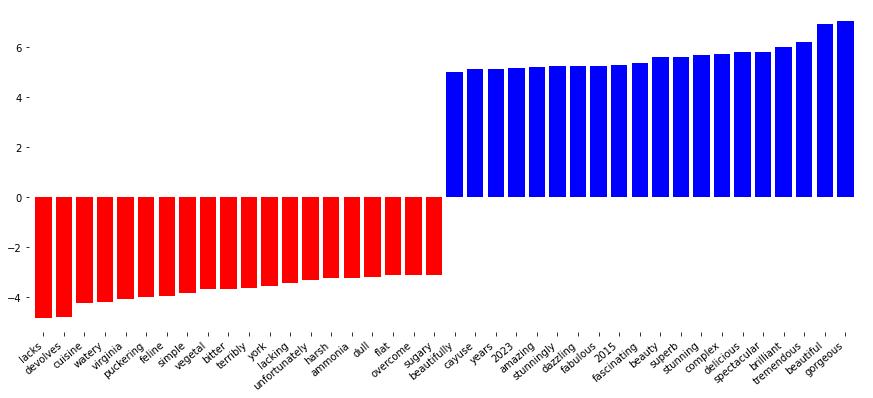

In [72]:
plt.figure(figsize=(15, 6))
plot_important_features(ridge.coef_.ravel(), np.array(tdif.get_feature_names()), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

In [73]:
def get_num_text_pipeline(df,regr_num,regr_text):
    numeric_cols = X_train.columns[X_train.columns.dtype != object].tolist()
    
    transformer_text = FunctionTransformer(lambda x: x['description'], validate=False)
    transfomer_numeric = FunctionTransformer(lambda x: x[numeric_cols], validate=False)

    pipeline = Pipeline([
        ('features', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', transfomer_numeric)
                ])),
                 ('text_features', Pipeline([
                    ('selector', transformer_text),
                    (regr_text.__class__.__name__, regr_text)
                ]))
             ])),
        ('estimator', regr_num)
    ])
    return pipeline

In [74]:
df_text_plus_numeric = us_df_cleaned.copy()
df_text_plus_numeric['description'] = us_df_filled['description']
X,y=get_label_and_drop(df_text_plus_numeric)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)

In [100]:
X_train.shape

(40698, 50)

In [76]:
regr_text = TfidfVectorizer(stop_words='english',min_df=4) #TBD try to run on all the text tokenizers

for regr in rergressors:
    pipe = get_num_text_pipeline(X_train,regr,regr_text)
    get_cross_val_score(scores_df,pipe, X_train, y_train,regr_text.__class__.__name__+"_combined")
scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression__char_wb,-0.160987
Lasso__count_vectorizer,-0.000694
ElasticNet__CountVectorizer_norma,-0.000694
Lasso__CountVectorizer_norma,-0.000694
ElasticNet__ngrm,-0.000694
ElasticNet_TfidfVectorizer,-0.000694
Lasso_TfidfVectorizer,-0.000694
ElasticNet__count_vectorizer,-0.000694
Lasso__ngrm,-0.000694
LinearRegression__ngrm,0.052293


In [77]:
scores_df.sort_values(by='r2',inplace=True)
scores_df.tail(5)

,r2
Ridge__count_vectorizer,0.583355
Ridge__ngrm,0.583355
Ridge_TfidfVectorizer,0.637929
LinearRegression_TfidfVectorizer_combined,0.674982
Ridge_TfidfVectorizer_combined,0.695558


## Task 2 Word Vectors [50pts]

Use a pretrained word-embedding (word2vec, glove or fasttext) for featurization instead of the bag-of-words model. Does this improve classification? How about combining the embedded words with the BoW model?

### spaCy

In [765]:
#worked for me from shell
pip install -U spacy

In [ ]:
#worked for me from shell
python -m spacy download en_core_web_lg

In [78]:
import spacy

In [79]:
nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "ner","lemmatizer"])

In [80]:
X,y=get_label_and_drop(df_text_plus_numeric)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)

In [81]:
text_trainval = X_train['description'].tolist()
docs_train = [nlp(d).vector for d in text_trainval]
X_train_txt = np.vstack(docs_train)
X_train_txt.shape

(40698, 300)

In [82]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train_txt, y_train,"word2vec")
scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression__char_wb,-0.160987
Lasso__count_vectorizer,-0.000694
ElasticNet__CountVectorizer_norma,-0.000694
Lasso__CountVectorizer_norma,-0.000694
ElasticNet__ngrm,-0.000694
ElasticNet_TfidfVectorizer,-0.000694
Lasso_TfidfVectorizer,-0.000694
ElasticNet__count_vectorizer,-0.000694
Lasso__ngrm,-0.000694
Lasso_TfidfVectorizer_combined,-0.000095


In [83]:
scores_df.sort_values(by='r2',inplace=True)
scores_df.tail(5)

,r2
Ridge__count_vectorizer,0.583355
Ridge__ngrm,0.583355
Ridge_TfidfVectorizer,0.637929
LinearRegression_TfidfVectorizer_combined,0.674982
Ridge_TfidfVectorizer_combined,0.695558


In [84]:
queries = [w for w in nlp.vocab if w.is_lower and w.prob >= -20]

def most_similar(word, count=10):
    by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
    return [w.orth_ for w in by_similarity[:count]]

most_similar(nlp("wine"))

['wine',
 'wines',
 'tasting',
 'winery',
 'grape',
 'grapes',
 'beer',
 'tastings',
 'pinot',
 'chardonnay']

### gensim - Doc2Vec

In [ ]:
#worked for me in shell
pip install --upgrade gensim

In [85]:
import gensim

In [86]:
def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(line), [i])


            
train_corpus = list(read_corpus(X_train['description']))
test_corpus = list(read_corpus(X_test['description'], tokens_only=True))

model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
model.build_vocab(train_corpus)

model.train(train_corpus, total_examples=model.corpus_count, epochs=55)

vectors = [model.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]

X_train = np.vstack(vectors)

X_train.shape
# test_vectors = [model.infer_vector(test_corpus[doc_id])
#                 for doc_id in range(len(test_corpus))]
# X_test = np.vstack(test_vectors)

(40698, 50)

In [87]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"gensim")
scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression__char_wb,-0.160987
Lasso__count_vectorizer,-0.000694
ElasticNet__CountVectorizer_norma,-0.000694
Lasso__CountVectorizer_norma,-0.000694
ElasticNet__ngrm,-0.000694
ElasticNet_TfidfVectorizer,-0.000694
Lasso_TfidfVectorizer,-0.000694
ElasticNet__count_vectorizer,-0.000694
Lasso__ngrm,-0.000694
Lasso_TfidfVectorizer_combined,-0.000095


In [88]:
scores_df.sort_values(by='r2',inplace=True)
scores_df.tail(5)

,r2
Ridge__count_vectorizer,0.583355
Ridge__CountVectorizer_norma,0.583355
Ridge_TfidfVectorizer,0.637929
LinearRegression_TfidfVectorizer_combined,0.674982
Ridge_TfidfVectorizer_combined,0.695558


### BoW + embedding

In [104]:
X,y=get_label_and_drop(df_text_plus_numeric)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)
text_trainval = X_train['description'].tolist()

In [110]:
bow = TfidfVectorizer(stop_words='english',min_df=4)
X_train_bow = bow.fit_transform(text_trainval)
X_train_bow.shape

(40698, 8132)

In [111]:
train_corpus = list(read_corpus(X_train['description']))

doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
doc2vec.build_vocab(train_corpus)

doc2vec.train(train_corpus, total_examples=doc2vec.corpus_count, epochs=55)

vectors = [doc2vec.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]

X_train_d2v = np.vstack(vectors)
X_train_d2v.shape

(40698, 50)

In [119]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [120]:
type(X_train_d2v)

numpy.ndarray

In [123]:
X_bow_array = X_train_bow.toarray()

In [124]:
type(X_bow_array)

numpy.ndarray

In [125]:
X_train_bow_d2v = np.concatenate((X_bow_array,X_train_d2v),axis=1)

In [127]:
X_train_bow_d2v.shape

(40698, 8182)

In [128]:
for regr in rergressors:
    get_cross_val_score(scores_df,regr, X_train_bow_d2v, y_train,"bow_d2vec")
scores_df

*********LinearRegression *********
*********Ridge *********
*********Lasso *********
*********ElasticNet *********


,r2
LinearRegression__char_wb,-0.160987
Lasso__count_vectorizer,-0.000694
ElasticNet__CountVectorizer_norma,-0.000694
Lasso__CountVectorizer_norma,-0.000694
ElasticNet__ngrm,-0.000694
ElasticNet_TfidfVectorizer,-0.000694
Lasso_TfidfVectorizer,-0.000694
ElasticNet__count_vectorizer,-0.000694
Lasso__ngrm,-0.000694
ElasticNet_TfidfVectorizer_combined,-0.000095


# Task 3 Transformers (bonus / optional) [50pts] - Like Extra Assignment with 50% weight

Fine-tune a BERT model on the text data alone using the transformers library. How does this model compare to a BoW model, and how does it compare to a model using all features?

In [93]:
from transformers import pipeline
import torch
import transformers
transformers.logging.set_verbosity_info()

In [94]:
nlp = pipeline("feature-extraction")

loading configuration file https://huggingface.co/distilbert-base-cased/resolve/main/config.json from cache at /home/zsofya/.cache/huggingface/transformers/ebe1ea24d11aa664488b8de5b21e33989008ca78f207d4e30ec6350b693f073f.302bfd1b5e031cc1b17796e0b6e5b242ba2045d31d00f97589e12b458ebff27a
Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.5.1",
  "vocab_size": 28996
}

https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /home/zsofya/.cache/huggingface/transformers/tmpt70z139w


Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin in cache at /home/zsofya/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
creating metadata file for /home/zsofya/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
loading weights file https://huggingface.co/distilbert-base-cased/resolve/main/pytorch_model.bin from cache at /home/zsofya/.cache/huggingface/transformers/9c9f39769dba4c5fe379b4bc82973eb01297bd607954621434eb9f1bc85a23a0.06b428c87335c1bb22eae46fdab31c8286efa0aa09e898a7ac42ddf5c3f5dc19
All model checkpoint weights were used when initializing DistilBertModel.

All the weights of DistilBertModel were initialized from the model checkpoint at distilbert-base-cased.
If your task is similar to the task the model of the checkpoin

In [95]:
nlp.model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [96]:
sampled = df_text_plus_numeric.sample(frac=0.2,random_state=42)

In [97]:
X,y=get_label_and_drop(df_text_plus_numeric)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)
text_trainval = X_train['description'].tolist()
X_train_txt = [nlp(t) for t in text_train]

In [1]:
X_train_txt

NameError: name 'X_train_txt' is not defined